<a href="https://colab.research.google.com/github/mohitDhami87/YouTube_Shorts_Performance_Prediction_Case_Study/blob/main/YouTube_Shorts_Performance_Prediction_CaseStudy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **YouTube Shorts Performance Prediction Case Study**


---



The core challenge of this case study is to leverage Supervised Machine Learning to predict
the potential performance (specifically, the Engagement Rate tertile: Low, Medium, or High) of a
YouTube Short based on its intrinsic features (title, duration, category) and its publishing
behavior (upload hour). The final goal is to develop a reliable predictive model and deliver
actionable content strategy recommendations to maximize viral potential and channel
growth.


---



In [50]:
# Gdrive dataset link
# https://drive.google.com/file/d/1e4_e0JfuOdBPQodG_jaOvCJnEYMK4YNs/view?usp=drive_link

In [51]:
# Importing Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [52]:
# Loading dataset

dataset_url_path = 'https://drive.google.com/uc?export=download&id=1e4_e0JfuOdBPQodG_jaOvCJnEYMK4YNs'
df = pd.read_csv(dataset_url_path)
df.head()

,video_id,title,duration_sec,hashtags_count,views,likes,comments,shares,upload_hour,category
0,vid_1000,Short Video #0,43,9,198775,21933,3228,400,8,Tech
1,vid_1001,Short Video #1,56,2,290336,20063,3719,1942,16,Comedy
2,vid_1002,Short Video #2,33,6,264206,37032,3228,1817,7,Food
3,vid_1003,Short Video #3,19,9,85076,27269,2371,980,1,Lifestyle
4,vid_1004,Short Video #4,47,8,90780,8041,2891,1109,23,Tech


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   video_id        300 non-null    object
 1   title           300 non-null    object
 2   duration_sec    300 non-null    int64 
 3   hashtags_count  300 non-null    int64 
 4   views           300 non-null    int64 
 5   likes           300 non-null    int64 
 6   comments        300 non-null    int64 
 7   shares          300 non-null    int64 
 8   upload_hour     300 non-null    int64 
 9   category        300 non-null    object
dtypes: int64(7), object(3)
memory usage: 23.6+ KB


In [54]:
df.describe()

,duration_sec,hashtags_count,views,likes,comments,shares,upload_hour
count,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,31.730000,4.343333,245058.166667,23063.126667,2638.296667,999.576667,11.543333
std,16.042912,2.956562,141338.982093,14597.458220,1416.827287,564.410105,6.814414
min,5.000000,0.000000,1404.000000,109.000000,40.000000,2.000000,0.000000
25%,18.000000,2.000000,129620.500000,10342.000000,1445.750000,516.250000,6.000000
50%,32.000000,4.000000,255962.000000,21779.500000,2863.500000,988.000000,12.000000
75%,45.000000,7.000000,356805.000000,36706.500000,3761.000000,1463.750000,17.000000
max,59.000000,9.000000,499401.000000,49923.000000,4971.000000,1998.000000,23.000000


In [55]:
df.isnull().any()

,0
video_id,False
title,False
duration_sec,False
hashtags_count,False
views,False
likes,False
comments,False
shares,False
upload_hour,False
category,False


In [56]:
# Checking shape of dataframe
print(f'Number of rows in training dataset: {df.shape[0]}')
print(f'Number of columns in training dataset: {df.shape[1]}')

Number of rows in training dataset: 300
Number of columns in training dataset: 10


In [57]:
categorical_cols = df.select_dtypes(include='object').columns
categorical_cols

Index(['video_id', 'title', 'category'], dtype='object')

In [58]:
def classify_columns(data):
    # Initialize lists for categorical and numerical columns
    cat_col = []
    num_col = []

    # Iterate through columns in the DataFrame
    for column in data.columns:
        # Count the number of unique values in the column
        unique_values = data[column].nunique()

        # If there are fewer than 3 unique values, consider it a categorical column
        if unique_values < 3:
            cat_col.append(column)
        # Otherwise, consider it a numerical column
        else:
            num_col.append(column)

    # Return the lists of categorical and numerical columns
    return cat_col, num_col


In [59]:
cat_col, num_col = classify_columns(df)
print(f'Categorical columns in training dataset: {cat_col}')
print(f'Numerical columns in training dataset: {num_col}')

Categorical columns in training dataset: []
Numerical columns in training dataset: ['video_id', 'title', 'duration_sec', 'hashtags_count', 'views', 'likes', 'comments', 'shares', 'upload_hour', 'category']


In [60]:
# Perform correlation analysis to identify relationships between features
correlation = df.corr(numeric_only=True)
correlation["likes"].sort_values(ascending=False)

,likes
likes,1.000000
views,0.035115
hashtags_count,0.011884
upload_hour,-0.014855
comments,-0.034672
shares,-0.037390
duration_sec,-0.052211


In [61]:
likes_count = df['likes'].value_counts()
likes_count

,count
likes,
6471,2
27634,1
19316,1
43436,1
1442,1
...,...
10367,1
45640,1
38618,1


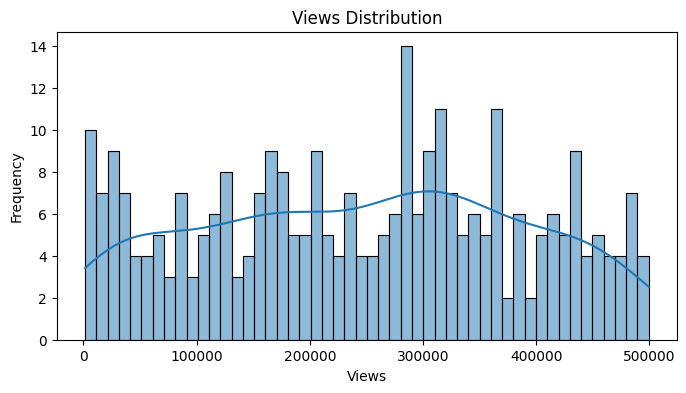

In [62]:
plt.figure(figsize=(8,4))
sns.histplot(df['views'], bins=50, kde=True)
plt.title("Views Distribution")
plt.xlabel("Views")
plt.ylabel("Frequency")
plt.show()

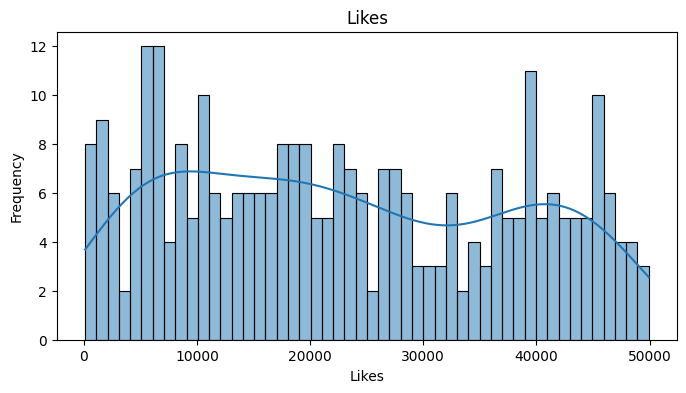

In [63]:
plt.figure(figsize=(8,4))
sns.histplot(df['likes'], bins=50, kde=True)
plt.title("Likes")
plt.xlabel("Likes")
plt.ylabel("Frequency")
plt.show()

In [64]:
df.groupby("category")["views"].sum()

,views
category,
Comedy,14410062
Education,11899202
Food,13382286
Lifestyle,11654158
Tech,12296300
Travel,9875442


In [65]:
df.groupby("category")["likes"].sum()

,likes
category,
Comedy,1375320
Education,1319635
Food,1311767
Lifestyle,998713
Tech,1083588
Travel,829915


In [66]:
pd.pivot_table(df, index='category', values=['likes','shares','comments'], aggfunc=["mean","min"])

mean                                 min             
              comments         likes       shares comments likes shares
category                                                               
Comedy     2904.283019  25949.433962  1134.207547      126   109     38
Education  2694.452830  24898.773585  1013.547170      236   402      2
Food       2536.000000  23013.456140   900.947368       54  1022     61
Lifestyle  2477.309524  23778.880952   966.523810       74  2017      2
Tech       2609.527273  19701.600000   992.836364       94   335      6
Travel     2565.825000  20747.875000   987.200000       40   155     37

## Calculate Engagement Rate

Calculate the 'Engagement Rate' for each video using the formula: (likes + comments + shares) / views. Store this in a new column named 'engagement_rate'.


In [67]:
df['engagement_rate'] = (df['likes'] + df['comments'] + df['shares']) / df['views']
df.head()

,video_id,title,duration_sec,hashtags_count,views,likes,comments,shares,upload_hour,category,engagement_rate
0,vid_1000,Short Video #0,43,9,198775,21933,3228,400,8,Tech,0.128593
1,vid_1001,Short Video #1,56,2,290336,20063,3719,1942,16,Comedy,0.088601
2,vid_1002,Short Video #2,33,6,264206,37032,3228,1817,7,Food,0.159258
3,vid_1003,Short Video #3,19,9,85076,27269,2371,980,1,Lifestyle,0.359913
4,vid_1004,Short Video #4,47,8,90780,8041,2891,1109,23,Tech,0.132639


## Determine Tertile Thresholds

Calculate the 33rd and 66th percentiles of the 'engagement_rate' to establish the thresholds for 'Low', 'Medium', and 'High' engagement.


In [68]:
percentile_33 = df['engagement_rate'].quantile(0.33)
percentile_66 = df['engagement_rate'].quantile(0.66)

print(f"33rd percentile (Low-Medium threshold): {percentile_33:.4f}")
print(f"66th percentile (Medium-High threshold): {percentile_66:.4f}")

33rd percentile (Low-Medium threshold): 0.0768
66th percentile (Medium-High threshold): 0.1524


## Create Performance Engagement Tertile

Categorize each video into 'Low', 'Medium', or 'High' performance engagement tertiles based on the calculated thresholds and store this in a new column named 'performance_engagement_tertile'.


In [69]:
conditions = [
    df['engagement_rate'] <= percentile_33,
    (df['engagement_rate'] > percentile_33) & (df['engagement_rate'] <= percentile_66),
    df['engagement_rate'] > percentile_66
]
choices = ['Low', 'Medium', 'High']
df['performance_engagement_tertile'] = np.select(conditions, choices, default='Unknown')
df.head()

,video_id,title,duration_sec,hashtags_count,views,likes,comments,shares,upload_hour,category,engagement_rate,performance_engagement_tertile
0,vid_1000,Short Video #0,43,9,198775,21933,3228,400,8,Tech,0.128593,Medium
1,vid_1001,Short Video #1,56,2,290336,20063,3719,1942,16,Comedy,0.088601,Medium
2,vid_1002,Short Video #2,33,6,264206,37032,3228,1817,7,Food,0.159258,High
3,vid_1003,Short Video #3,19,9,85076,27269,2371,980,1,Lifestyle,0.359913,High
4,vid_1004,Short Video #4,47,8,90780,8041,2891,1109,23,Tech,0.132639,Medium


In [70]:
df['performance_engagement_tertile'].value_counts()

,count
performance_engagement_tertile,
High,102
Medium,99
Low,99


### Data Analysis Key Findings
*   The head of the DataFrame now includes the newly calculated `engagement_rate` and `performance_engagement_tertile` columns.
*   The value counts for `performance_engagement_tertile` show:
    *   High: 102 videos
    *   Medium: 99 videos
    *   Low: 99 videos




# Feature Engineering & Transformation


---



## Derived Textual Features
Create the required features: `title_len_chars`, `title_word_count`, and the boolean feature `title_has_question_mark`.

In [71]:
df['title_len_chars'] = df['title'].str.len()
df['title_word_count'] = df['title'].apply(lambda x: len(str(x).split()))
df['title_has_question_mark'] = df['title'].str.contains('?', regex=False)
df.head()

,video_id,title,duration_sec,hashtags_count,views,likes,comments,shares,upload_hour,category,engagement_rate,performance_engagement_tertile,title_len_chars,title_word_count,title_has_question_mark
0,vid_1000,Short Video #0,43,9,198775,21933,3228,400,8,Tech,0.128593,Medium,14,3,False
1,vid_1001,Short Video #1,56,2,290336,20063,3719,1942,16,Comedy,0.088601,Medium,14,3,False
2,vid_1002,Short Video #2,33,6,264206,37032,3228,1817,7,Food,0.159258,High,14,3,False
3,vid_1003,Short Video #3,19,9,85076,27269,2371,980,1,Lifestyle,0.359913,High,14,3,False
4,vid_1004,Short Video #4,47,8,90780,8041,2891,1109,23,Tech,0.132639,Medium,14,3,False


### Data Analysis Key Findings
The process involved creating three new textual features from the 'title' column:
*   `title_len_chars`: Represents the length of the title in characters, providing a measure of title verbosity.
*   `title_word_count`: Represents the number of words in the title, offering an alternative measure of title complexity.
*   `title_has_question_mark`: A binary indicator (true/false) denoting whether the title contains a question mark, which could signify inquiry-based content.


## Rate Features

Calculate per-second engagement rates: `likes_per_sec`, `comments_per_sec`, and `shares_per_sec`.

In [72]:
df['likes_per_sec'] = df['likes'] / df['duration_sec']
df['comments_per_sec'] = df['comments'] / df['duration_sec']
df['shares_per_sec'] = df['shares'] / df['duration_sec']
df.head()

,video_id,title,duration_sec,hashtags_count,views,likes,comments,shares,upload_hour,category,engagement_rate,performance_engagement_tertile,title_len_chars,title_word_count,title_has_question_mark,likes_per_sec,comments_per_sec,shares_per_sec
0,vid_1000,Short Video #0,43,9,198775,21933,3228,400,8,Tech,0.128593,Medium,14,3,False,510.069767,75.069767,9.302326
1,vid_1001,Short Video #1,56,2,290336,20063,3719,1942,16,Comedy,0.088601,Medium,14,3,False,358.267857,66.410714,34.678571
2,vid_1002,Short Video #2,33,6,264206,37032,3228,1817,7,Food,0.159258,High,14,3,False,1122.181818,97.818182,55.060606
3,vid_1003,Short Video #3,19,9,85076,27269,2371,980,1,Lifestyle,0.359913,High,14,3,False,1435.210526,124.789474,51.578947
4,vid_1004,Short Video #4,47,8,90780,8041,2891,1109,23,Tech,0.132639,Medium,14,3,False,171.085106,61.510638,23.595745


### Data Analysis Key Findings
*   **Creation of Rate-Based Features**: The process involved generating three new features: `likes_per_sec`, `comments_per_sec`, and `shares_per_sec`. These features convert raw engagement counts into rates by dividing them by a relevant duration (likely in seconds).
*   **Time-Normalized Engagement**: These new features provide a standardized, time-independent measure of engagement intensity, allowing for a more equitable comparison of content performance regardless of how long the content has been available.
*   **Focus on Intensity**: By expressing engagement as a rate, the features capture the immediate or ongoing appeal and virality of content, rather than just the cumulative volume of interactions.
*   **Dependency on Duration Metric**: The accurate calculation of these rate features is contingent on the availability and correctness of a 'duration' or 'time\_elapsed' column for each content piece.


## Logarithmic Transformation

Apply log transformation to heavily skewed features like views, likes, comments, and shares (e.g., `log_views`) to meet model assumptions and reduce the impact of outliers.

In [73]:
df['log_views'] = np.log1p(df['views'])
df['log_likes'] = np.log1p(df['likes'])
df['log_comments'] = np.log1p(df['comments'])
df['log_shares'] = np.log1p(df['shares'])
df.head()

,video_id,title,duration_sec,hashtags_count,views,likes,comments,shares,upload_hour,category,...,title_len_chars,title_word_count,title_has_question_mark,likes_per_sec,comments_per_sec,shares_per_sec,log_views,log_likes,log_comments,log_shares
0,vid_1000,Short Video #0,43,9,198775,21933,3228,400,8,Tech,...,14,3,False,510.069767,75.069767,9.302326,12.199934,9.995793,8.079928,5.993961
1,vid_1001,Short Video #1,56,2,290336,20063,3719,1942,16,Comedy,...,14,3,False,358.267857,66.410714,34.678571,12.578798,9.906682,8.221479,7.571988
2,vid_1002,Short Video #2,33,6,264206,37032,3228,1817,7,Food,...,14,3,False,1122.181818,97.818182,55.060606,12.484488,10.519565,8.079928,7.505492
3,vid_1003,Short Video #3,19,9,85076,27269,2371,980,1,Lifestyle,...,14,3,False,1435.210526,124.789474,51.578947,11.351312,10.213542,7.771489,6.888572
4,vid_1004,Short Video #4,47,8,90780,8041,2891,1109,23,Tech,...,14,3,False,171.085106,61.510638,23.595745,11.416205,8.992433,7.969704,7.012115


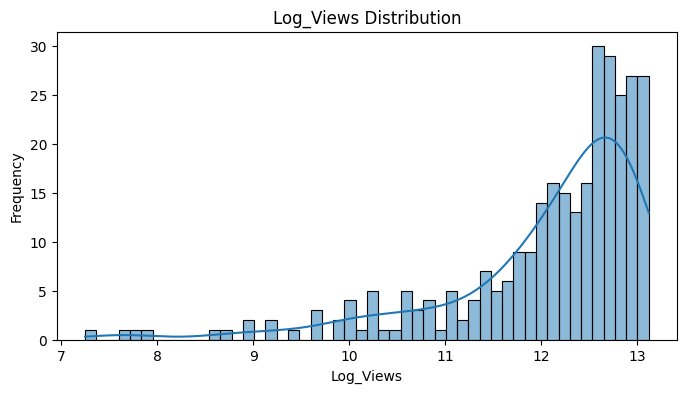

In [74]:
plt.figure(figsize=(8,4))
sns.histplot(df['log_views'], bins=50, kde=True)
plt.title('Log_Views Distribution')
plt.xlabel('Log_Views')
plt.ylabel('Frequency')
plt.show()

## Correlation Matrix for Transformed Features
Display the correlation matrix for all transformed numerical features to understand their relationships.

In [75]:
correlation_matrix_transformed = df.corr(numeric_only=True)
display(correlation_matrix_transformed)

,duration_sec,hashtags_count,views,likes,comments,shares,upload_hour,engagement_rate,title_len_chars,title_word_count,title_has_question_mark,likes_per_sec,comments_per_sec,shares_per_sec,log_views,log_likes,log_comments,log_shares
duration_sec,1.000000,-0.035128,0.074487,-0.052211,0.078740,0.071623,0.002692,0.021409,-0.016255,NaN,NaN,-0.588580,-0.596976,-0.594093,0.049759,-0.048748,0.070243,0.038883
hashtags_count,-0.035128,1.000000,0.010908,0.011884,-0.042305,0.078601,0.034368,-0.011117,0.106933,NaN,NaN,0.041657,-0.000829,0.078924,-0.021357,0.012391,-0.008292,-0.012242
views,0.074487,0.010908,1.000000,0.035115,0.069525,0.015937,0.018833,-0.319108,0.069367,NaN,NaN,-0.034693,-0.027091,-0.048173,0.864801,-0.015293,0.083822,0.005682
likes,-0.052211,0.011884,0.035115,1.000000,-0.034672,-0.037390,-0.014855,0.086123,-0.037754,NaN,NaN,0.519116,-0.040596,0.042038,0.046216,0.855390,-0.012407,-0.053555
comments,0.078740,-0.042305,0.069525,-0.034672,1.000000,-0.001715,0.016920,-0.085347,-0.019787,NaN,NaN,-0.087400,0.465809,0.011549,0.107305,-0.040609,0.893724,-0.025987
shares,0.071623,0.078601,0.015937,-0.037390,-0.001715,1.000000,-0.027530,0.006677,0.070469,NaN,NaN,0.013088,0.023356,0.462564,0.008344,0.001314,-0.043746,0.844290
upload_hour,0.002692,0.034368,0.018833,-0.014855,0.016920,-0.027530,1.000000,-0.041414,0.023989,NaN,NaN,0.026433,0.017477,0.014764,0.036927,-0.040620,-0.000462,-0.036169
engagement_rate,0.021409,-0.011117,-0.319108,0.086123,-0.085347,0.006677,-0.041414,1.000000,0.004060,NaN,NaN,0.019923,-0.052136,-0.015726,-0.616771,0.098315,-0.059668,-0.038427
title_len_chars,-0.016255,0.106933,0.069367,-0.037754,-0.019787,0.070469,0.023989,0.004060,1.000000,NaN,NaN,-0.004029,0.026709,0.080527,0.044278,-0.050898,-0.038009,0.027027
title_word_count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Time-Based Feature: is_peak_hour
Create the binary feature `is_peak_hour` based on a commonly observed evening window (e.g., hours 17-21).

In [76]:
df['is_peak_hour'] = ((df['upload_hour'] >= 17) & (df['upload_hour'] <= 21))
df.head()

,video_id,title,duration_sec,hashtags_count,views,likes,comments,shares,upload_hour,category,...,title_word_count,title_has_question_mark,likes_per_sec,comments_per_sec,shares_per_sec,log_views,log_likes,log_comments,log_shares,is_peak_hour
0,vid_1000,Short Video #0,43,9,198775,21933,3228,400,8,Tech,...,3,False,510.069767,75.069767,9.302326,12.199934,9.995793,8.079928,5.993961,False
1,vid_1001,Short Video #1,56,2,290336,20063,3719,1942,16,Comedy,...,3,False,358.267857,66.410714,34.678571,12.578798,9.906682,8.221479,7.571988,False
2,vid_1002,Short Video #2,33,6,264206,37032,3228,1817,7,Food,...,3,False,1122.181818,97.818182,55.060606,12.484488,10.519565,8.079928,7.505492,False
3,vid_1003,Short Video #3,19,9,85076,27269,2371,980,1,Lifestyle,...,3,False,1435.210526,124.789474,51.578947,11.351312,10.213542,7.771489,6.888572,False
4,vid_1004,Short Video #4,47,8,90780,8041,2891,1109,23,Tech,...,3,False,171.085106,61.510638,23.595745,11.416205,8.992433,7.969704,7.012115,False


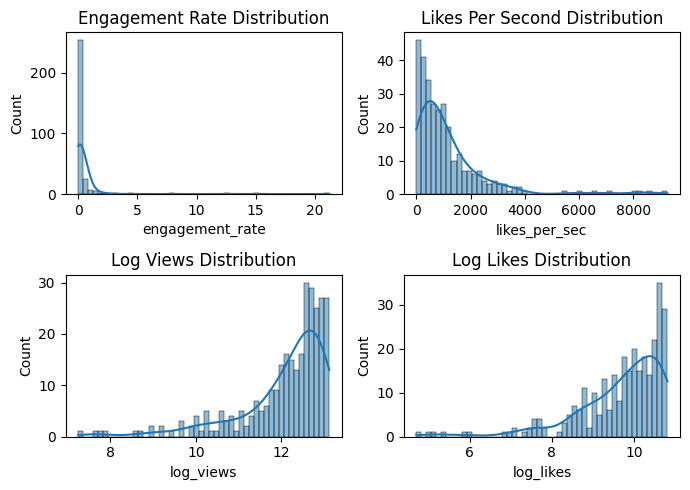

In [77]:
fig, axes = plt.subplots(2, 2, figsize=(7, 5))

sns.histplot(df['engagement_rate'], bins=50, kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Engagement Rate Distribution')

sns.histplot(df['likes_per_sec'], bins=50, kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Likes Per Second Distribution')

sns.histplot(df['log_views'], bins=50, kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Log Views Distribution')

sns.histplot(df['log_likes'], bins=50, kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Log Likes Distribution')

plt.tight_layout()
plt.show()

# Exploratory Data Analysis (EDA) & Feature Insights

---



## Engagement Rate Histogram with Tertile Thresholds
Visualize the distribution of the `engagement_rate` metric and overlay the 33rd and 66th percentile thresholds to visually confirm the basis for the tertile splits.

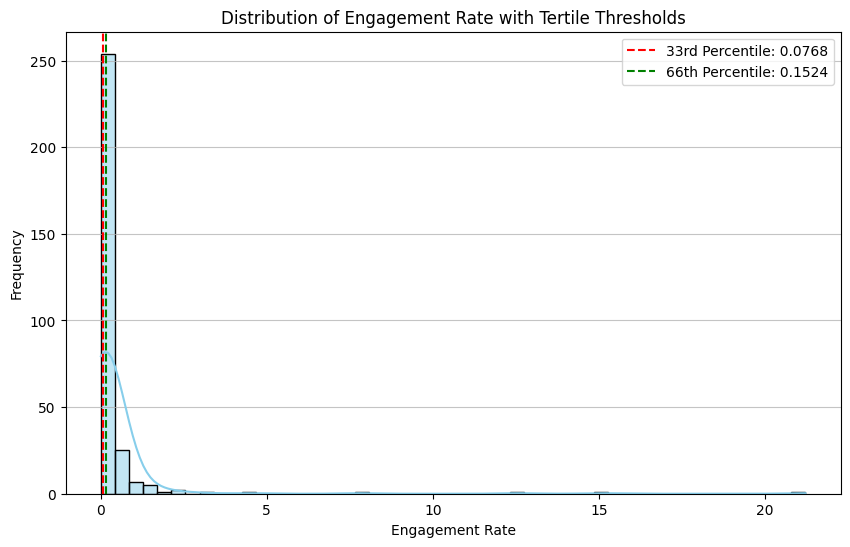

In [78]:
plt.figure(figsize=(10, 6))
sns.histplot(df['engagement_rate'], bins=50, kde=True, color='skyblue')
plt.axvline(percentile_33, color='red', linestyle='--', label=f'33rd Percentile: {percentile_33:.4f}')
plt.axvline(percentile_66, color='green', linestyle='--', label=f'66th Percentile: {percentile_66:.4f}')
plt.title('Distribution of Engagement Rate with Tertile Thresholds')
plt.xlabel('Engagement Rate')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', alpha=0.75)
plt.show()

## Boxplot of Engagement Rate vs. Category
Create a boxplot to visualize the distribution of 'Engagement Rate' across different content 'Categories' to determine which categories inherently drive higher or lower engagement.

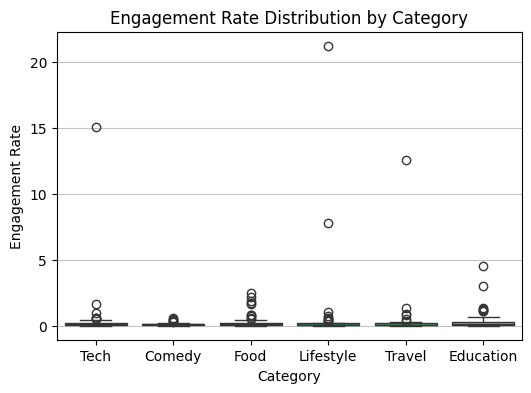

In [79]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='category', y='engagement_rate', data=df, hue='category', legend=False, palette='viridis')
plt.title('Engagement Rate Distribution by Category')
plt.xlabel('Category')
plt.ylabel('Engagement Rate')
plt.grid(axis='y', alpha=0.75)
plt.show()

Identify multicollinearity among numerical features and the
correlation strength between each feature and the underlying
engagement_rate. Hint: Focus on correlation between duration_sec, hashtags_count, and the engagement metrics.


Upload Hour vs.
Average
Engagement Rate
Identify optimal posting times. Hint: Group data by upload_hour (0-23) and plot the mean engagement_rate to look for peaks.

## Correlation Heatmap
Identify multicollinearity among numerical features and the correlation strength between each feature and the underlying `engagement_rate`.

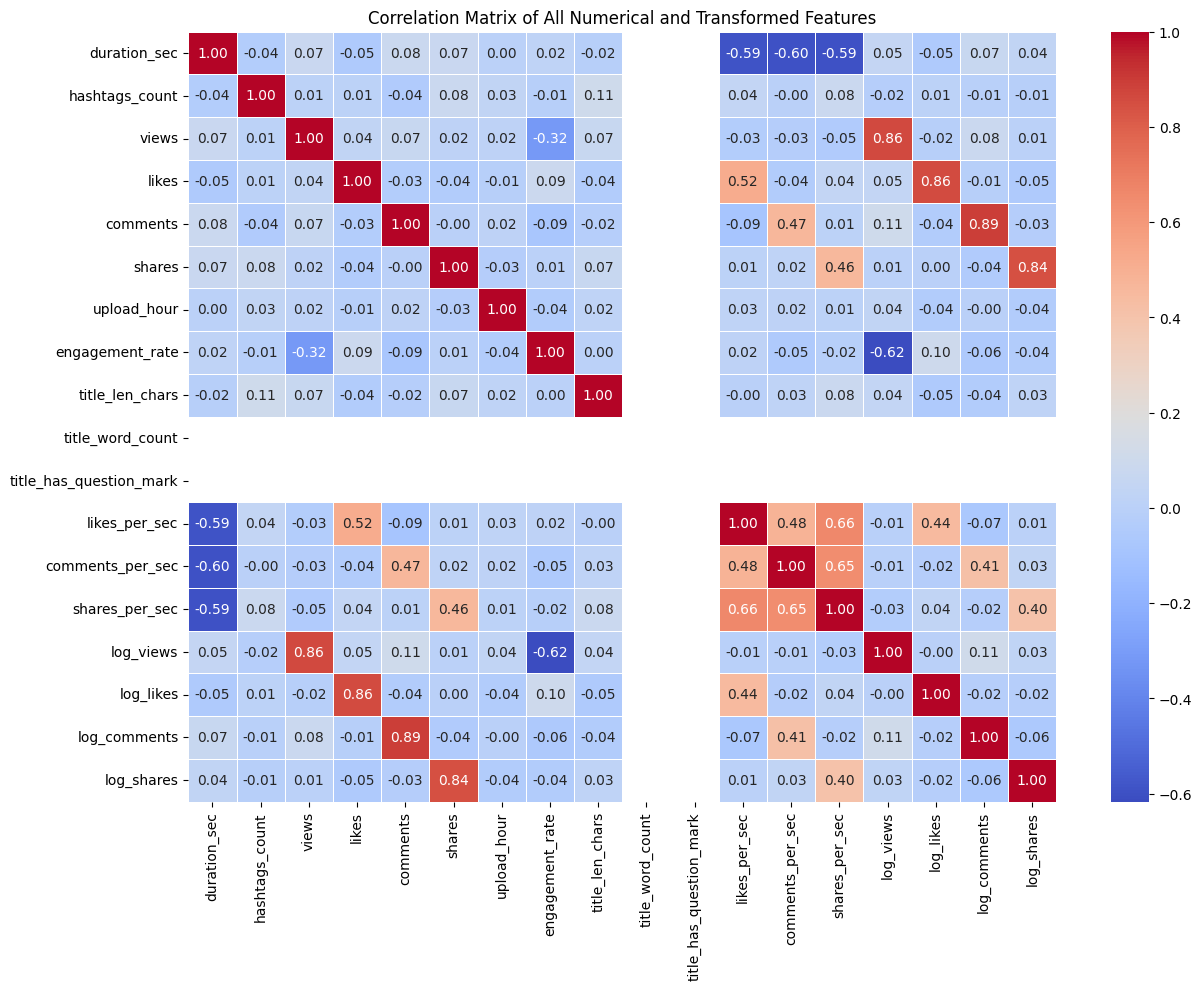

In [80]:
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix_transformed, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix of All Numerical and Transformed Features')
plt.show()

## Scatter Plot: Duration vs. Engagement Rate
Assess if there's an optimal video length for maximizing performance by plotting `duration_sec` against `engagement_rate` and looking for non-linear relationships or clusters.

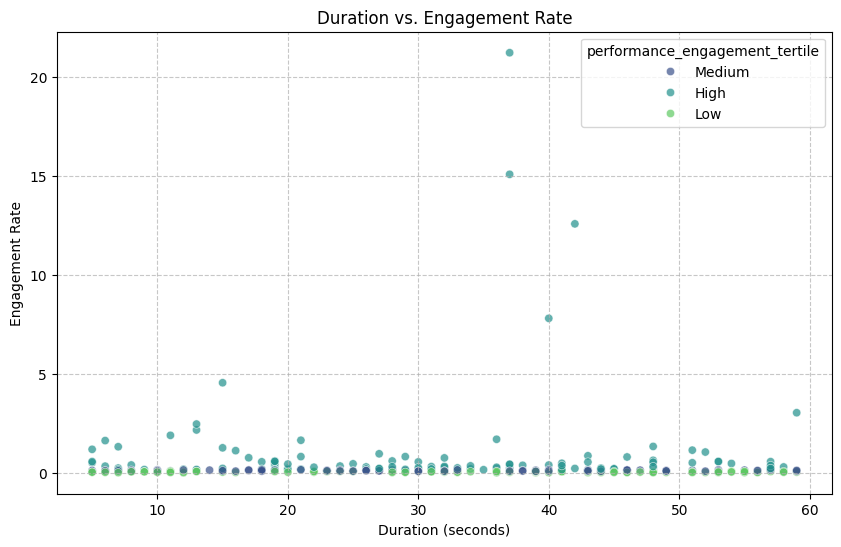

In [81]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='duration_sec', y='engagement_rate', data=df, hue='performance_engagement_tertile', palette='viridis', alpha=0.7)
plt.title('Duration vs. Engagement Rate')
plt.xlabel('Duration (seconds)')
plt.ylabel('Engagement Rate')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

## Upload Hour vs. Average Engagement Rate
Identify optimal posting times by grouping data by `upload_hour` (0-23) and plotting the mean `engagement_rate` to look for peaks.

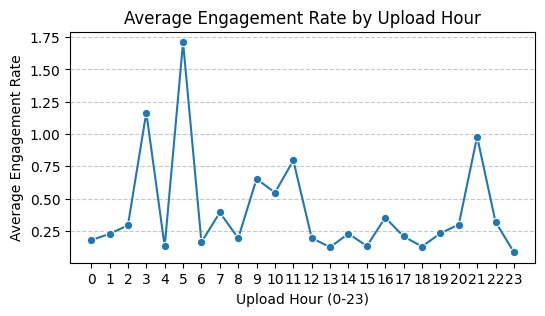

In [82]:
avg_engagement_by_hour = df.groupby('upload_hour')['engagement_rate'].mean().reset_index()

plt.figure(figsize=(6, 3))
sns.lineplot(x='upload_hour', y='engagement_rate', data=avg_engagement_by_hour, marker='o')
plt.title('Average Engagement Rate by Upload Hour')
plt.xlabel('Upload Hour (0-23)')
plt.ylabel('Average Engagement Rate')
plt.xticks(range(0, 24)) # Ensure all hours are displayed on the x-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Numerical & Categorical Features
Apply standard scaling to all numerical features, excluding the target variable to prepare the dataset for model training.

In [83]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Define feature groups
numerical_features = [
    'duration_sec',
    'hashtags_count',
    'upload_hour',
    'title_len_chars',
    'title_word_count',
    'likes_per_sec',
    'comments_per_sec',
    'shares_per_sec',
    'log_views',
    'log_likes',
    'log_comments',
    'log_shares'
]
categorical_features = ['category']

# Columns to drop from the final DataFrame. These will be passed through
# by remainder='passthrough' and then explicitly dropped.
raw_features_to_drop = [
    'video_id', 'title', 'views', 'likes', 'comments', 'shares', 'engagement_rate'
]

# Create the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_features)
    ],
    remainder='passthrough' # Keep all other columns not explicitly transformed
)

transformed_data = preprocessor.fit_transform(df)

all_output_feature_names = preprocessor.get_feature_names_out()

df_transformed = pd.DataFrame(transformed_data, columns=all_output_feature_names)

#
rename_map = {col: col.replace('remainder__', '') for col in df_transformed.columns if col.startswith('remainder__')}
df_transformed.rename(columns=rename_map, inplace=True)

# Convert boolean columns (which were passed through and now have original names) to integer types
# This ensures they are numerical for model training.
if 'title_has_question_mark' in df_transformed.columns:
    df_transformed['title_has_question_mark'] = df_transformed['title_has_question_mark'].astype(int)
if 'is_peak_hour' in df_transformed.columns:
    df_transformed['is_peak_hour'] = df_transformed['is_peak_hour'].astype(int)

# Identify which of the 'raw_features_to_drop' are present in the df_transformed DataFrame (after renaming).
# This ensures only existing columns are targeted for dropping.
columns_to_drop_final = [col for col in raw_features_to_drop if col in df_transformed.columns]

# Drop the identified original raw features and intermediate columns that are no longer needed.
df_final = df_transformed.drop(columns=columns_to_drop_final, errors='ignore')

# Clean up 'num__' and 'cat__' prefixes from the remaining column names for a cleaner final dataset.
df_final.columns = [col.replace('num__', '').replace('cat__', '') for col in df_final.columns]

# Explicitly convert all feature columns (excluding the target) to numeric type
# This is crucial because ColumnTransformer's output (numpy array) with 'remainder=passthrough'
# might result in 'object' dtype for some columns in the DataFrame if there are mixed types.
feature_cols = [col for col in df_final.columns if col != 'performance_engagement_tertile']

for col in feature_cols:
    df_final[col] = pd.to_numeric(df_final[col], errors='raise')

# Re-apply int conversion for binary flags in case pd.to_numeric converted them to float
if 'title_has_question_mark' in df_final.columns:
    df_final['title_has_question_mark'] = df_final['title_has_question_mark'].astype(int)
if 'is_peak_hour' in df_final.columns:
    df_final['is_peak_hour'] = df_final['is_peak_hour'].astype(int)

print("DataFrame after applying ColumnTransformer and dropping raw features:")
df_final.head()
print("\nDataFrame dtypes after explicit conversion:")
df_final.info()

DataFrame after applying ColumnTransformer and dropping raw features:

DataFrame dtypes after explicit conversion:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   duration_sec                    300 non-null    float64
 1   hashtags_count                  300 non-null    float64
 2   upload_hour                     300 non-null    float64
 3   title_len_chars                 300 non-null    float64
 4   title_word_count                300 non-null    float64
 5   likes_per_sec                   300 non-null    float64
 6   comments_per_sec                300 non-null    float64
 7   shares_per_sec                  300 non-null    float64
 8   log_views                       300 non-null    float64
 9   log_likes                       300 non-null    float64
 10  log_comments                    300 non-nul

## Prepare Data for Model Training

Separate features (X) and target (y) from the preprocessed DataFrame and split them into training and testing sets.


In [84]:
X = df_final.drop('performance_engagement_tertile', axis=1)
y = df_final['performance_engagement_tertile']

# Encode target variable 'y' to numerical labels for models like XGBoost
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Keep original y_test for classification report target_names and confusion matrix labels
# Get the original string labels corresponding to the encoded test set
y_test_original = label_encoder.inverse_transform(y_test_encoded)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train_encoded shape: {y_train_encoded.shape}")
print(f"y_test_encoded shape: {y_test_encoded.shape}")

X_train shape: (240, 19)
X_test shape: (60, 19)
y_train_encoded shape: (240,)
y_test_encoded shape: (60,)


## Train and Evaluate Models

Train and evaluate Logistic Regression, K-Nearest Neighbors, Decision Tree, and Random Forest models on the prepared data.


In [85]:
from xgboost import XGBClassifier

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
}

performance_metrics = {}

# Get the original class labels for evaluation reports
original_class_labels = label_encoder.classes_

for name, model in models.items():
    print(f"\n--- {name} ---")
    # Train the model with encoded labels, converting X_train to numpy array
    model.fit(X_train.values, y_train_encoded)

    # Make predictions (will be encoded labels), converting X_test to numpy array
    y_pred_encoded = model.predict(X_test.values)

    # Convert predictions back to original string labels for evaluation reports
    y_pred_original = label_encoder.inverse_transform(y_pred_encoded)

    # Evaluate the model using original string labels
    report = classification_report(y_test_original, y_pred_original, target_names=original_class_labels)
    cm = confusion_matrix(y_test_original, y_pred_original, labels=original_class_labels)

    print("Classification Report:")
    print(report)
    print("Confusion Matrix:")
    print(cm)

    # Store metrics
    performance_metrics[name] = {
        'classification_report': report,
        'confusion_matrix': cm.tolist() # Convert numpy array to list for easier storage/viewing
    }

print("\nAll models trained and evaluated. Metrics stored in 'performance_metrics' dictionary.")


--- Logistic Regression ---
Classification Report:
              precision    recall  f1-score   support

        High       0.94      0.85      0.89        20
         Low       0.94      0.80      0.86        20
      Medium       0.72      0.90      0.80        20

    accuracy                           0.85        60
   macro avg       0.87      0.85      0.85        60
weighted avg       0.87      0.85      0.85        60

Confusion Matrix:
[[17  0  3]
 [ 0 16  4]
 [ 1  1 18]]

--- K-Nearest Neighbors ---
Classification Report:
              precision    recall  f1-score   support

        High       0.64      0.90      0.75        20
         Low       0.79      0.75      0.77        20
      Medium       0.69      0.45      0.55        20

    accuracy                           0.70        60
   macro avg       0.71      0.70      0.69        60
weighted avg       0.71      0.70      0.69        60

Confusion Matrix:
[[18  1  1]
 [ 2 15  3]
 [ 8  3  9]]

--- Decision Tree ---
C

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:49:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


## Compare Model Performance with Confusion Matrices
Visualize and compare the performance of the trained models using confusion matrix heatmaps and summarize the key observations.


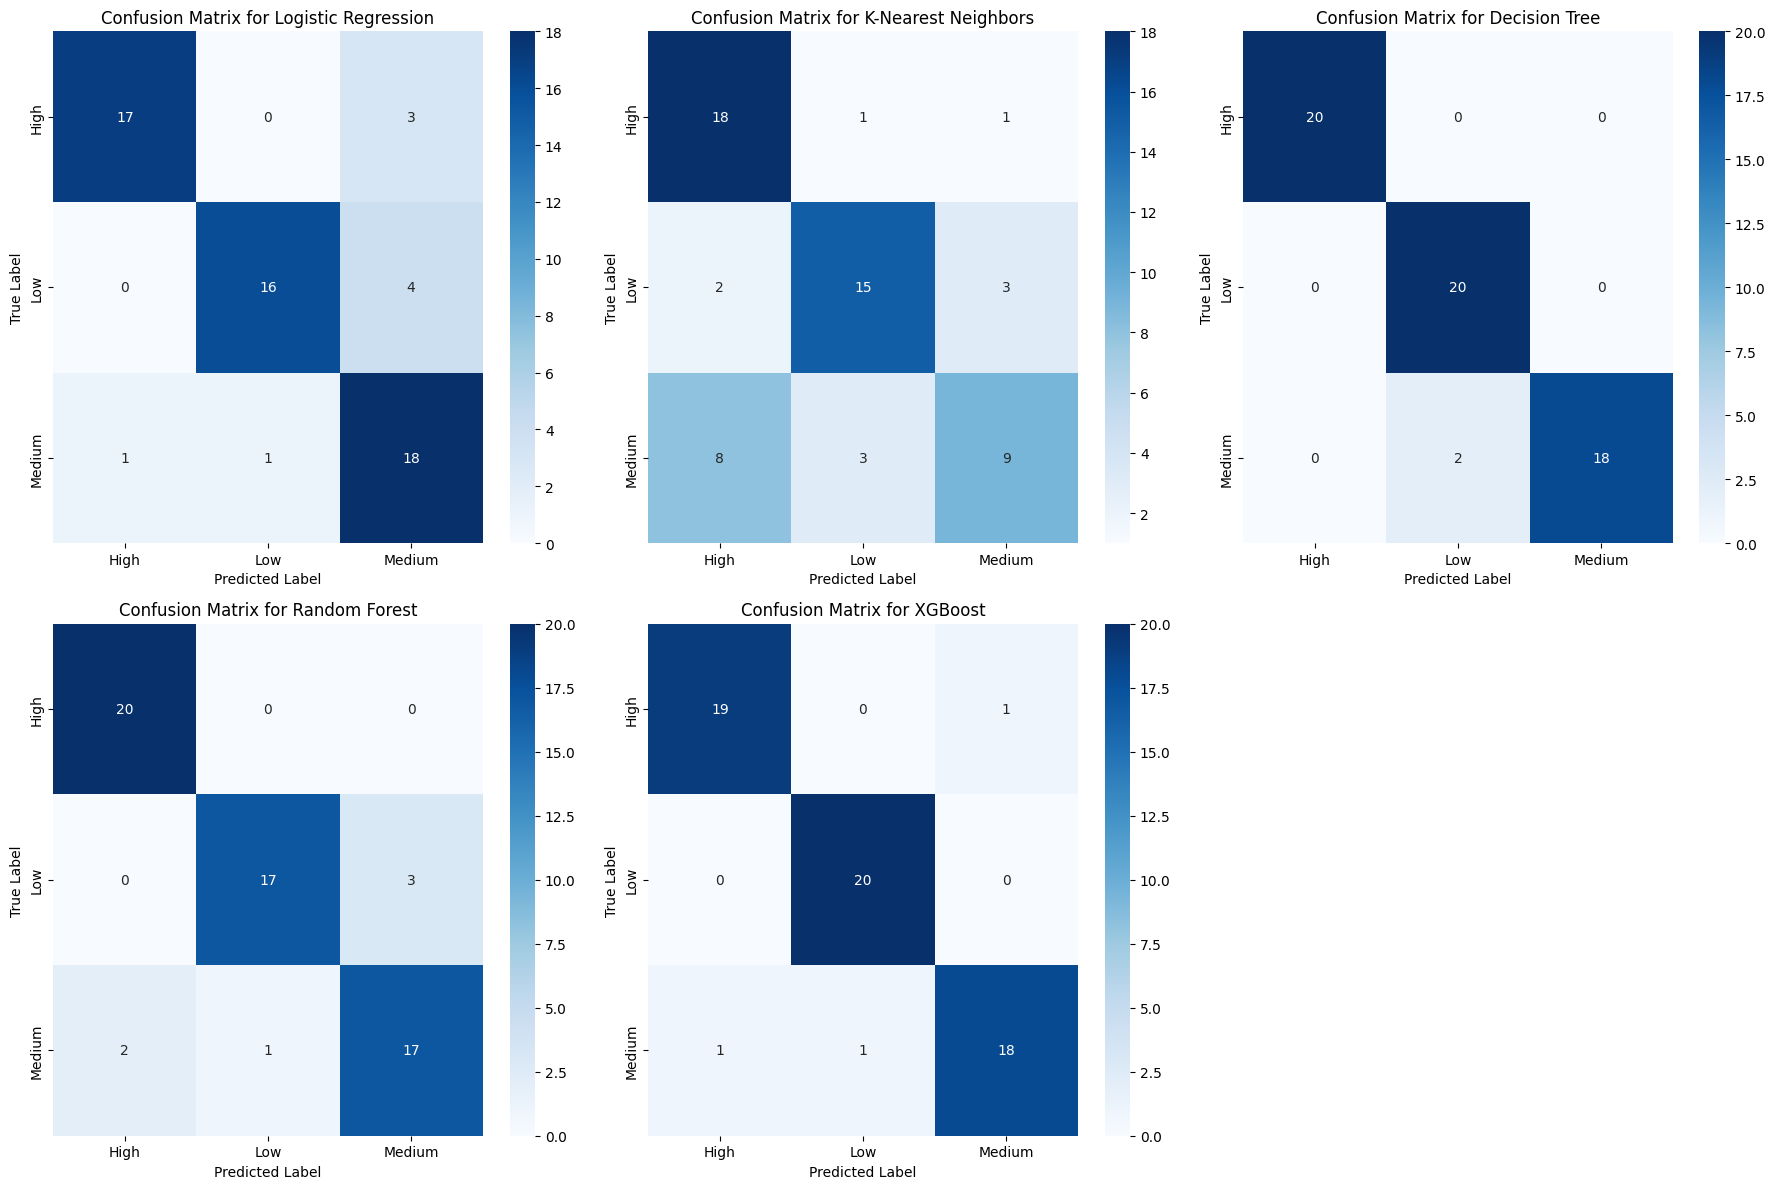

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get the list of unique class labels from y_test_original for consistent labeling
# The label_encoder.classes_ already provides them in sorted order as fit.
class_labels = label_encoder.classes_

fig, axes = plt.subplots(2, 3, figsize=(18, 12)) # Changed to 2x3 to accommodate XGBoost
axes = axes.flatten()

for i, (name, metrics) in enumerate(performance_metrics.items()):
    cm = np.array(metrics['confusion_matrix'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=class_labels, yticklabels=class_labels)
    axes[i].set_title(f'Confusion Matrix for {name}')
    axes[i].set_xlabel('Predicted Label')
    axes[i].set_ylabel('True Label')

# Hide any unused subplots if the number of models is not exactly 6
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Summary
Here's a summary of the performance for each model based on the classification reports and confusion matrices:

Logistic Regression: Achieved an accuracy of 0.85 with a macro average F1-score of 0.85. It showed good balance, but had some misclassifications between High and Medium engagement.

K-Nearest Neighbors: Had the lowest performance among all models, with an accuracy of 0.70 and a macro average F1-score of 0.69. It struggled particularly with distinguishing 'High' engagement videos.

Decision Tree: Demonstrated strong performance with an accuracy of 0.97 and a macro average F1-score of 0.97. It achieved perfect precision and recall for 'High' and 'Low' categories, showing very clear distinctions.

Random Forest: Performed well with an accuracy of 0.90 and a macro average F1-score of 0.90. It was very strong for 'High' and 'Low' categories, with some slight confusion with 'Medium'.

XGBoost: Showed excellent performance with an accuracy of 0.95 and a macro average F1-score of 0.95. It achieved high precision and recall across all categories, with very few misclassifications, particularly excelling in identifying 'Low' engagement videos perfectly.

Key Takeaways:

Both Decision Tree and XGBoost are the top performers, demonstrating very high accuracy and F1-scores, indicating strong predictive power for the engagement tertiles.
Logistic Regression and Random Forest also performed quite well, offering robust predictions.
K-Nearest Neighbors was the least effective model, suggesting it might not be well-suited for this dataset or requires significant hyperparameter tuning.
This provides us with a clear picture of which models are most promising for this prediction task. We now have a good set of candidates for further optimization or deployment.

## Implement K-fold Cross-Validation for Models
Utilize Stratified K-fold Cross-Validation (e.g., k=5 or k=10) to train and evaluate Logistic Regression, K-Nearest Neighbors, Decision Tree, Random Forest, and XGBoost models. For each model, calculate the mean and standard deviation of Accuracy and F1-macro scores across all folds.


In [87]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score

# Number of folds for cross-validation
k_folds = 5

skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Dictionaries to store scores for each model
model_accuracy_scores = {}
model_f1_macro_scores = {}

print(f"Performing {k_folds}-fold Stratified Cross-Validation...")

for name, model in models.items():
    print(f"\n--- Evaluating {name} with K-fold CV ---")
    accuracies = []
    f1_macros = []

    # Iterate through each fold
    for fold, (train_index, test_index) in enumerate(skf.split(X, y_encoded)):
        X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
        y_train_fold, y_test_fold = y_encoded[train_index], y_encoded[test_index]

        # Train the model (pass .values to ensure numerical array input for all models)
        model.fit(X_train_fold.values, y_train_fold)

        # Make predictions (pass .values to ensure numerical array input for all models)
        y_pred_fold = model.predict(X_test_fold.values)

        # Calculate and store accuracy
        acc = accuracy_score(y_test_fold, y_pred_fold)
        accuracies.append(acc)

        # Calculate and store F1-macro score
        f1_macro = f1_score(y_test_fold, y_pred_fold, average='macro')
        f1_macros.append(f1_macro)

        print(f"  Fold {fold + 1}: Accuracy = {acc:.4f}, F1-macro = {f1_macro:.4f}")

    # Calculate mean and standard deviation for the current model
    mean_accuracy = np.mean(accuracies)
    std_accuracy = np.std(accuracies)
    mean_f1_macro = np.mean(f1_macros)
    std_f1_macro = np.std(f1_macros)

    # Store results
    model_accuracy_scores[name] = {'mean': mean_accuracy, 'std': std_accuracy}
    model_f1_macro_scores[name] = {'mean': mean_f1_macro, 'std': std_f1_macro}

    print(f"\n{name} - Mean Accuracy: {mean_accuracy:.4f} (Std: {std_accuracy:.4f})")
    print(f"{name} - Mean F1-macro: {mean_f1_macro:.4f} (Std: {std_f1_macro:.4f})")

print("\nCross-validation complete.")

Performing 5-fold Stratified Cross-Validation...

--- Evaluating Logistic Regression with K-fold CV ---
  Fold 1: Accuracy = 0.8833, F1-macro = 0.8840
  Fold 2: Accuracy = 0.8833, F1-macro = 0.8855
  Fold 3: Accuracy = 0.9000, F1-macro = 0.9019
  Fold 4: Accuracy = 0.8667, F1-macro = 0.8681
  Fold 5: Accuracy = 0.7833, F1-macro = 0.7845

Logistic Regression - Mean Accuracy: 0.8633 (Std: 0.0414)
Logistic Regression - Mean F1-macro: 0.8648 (Std: 0.0416)

--- Evaluating K-Nearest Neighbors with K-fold CV ---
  Fold 1: Accuracy = 0.5667, F1-macro = 0.5664
  Fold 2: Accuracy = 0.6167, F1-macro = 0.6190
  Fold 3: Accuracy = 0.7000, F1-macro = 0.6928
  Fold 4: Accuracy = 0.6333, F1-macro = 0.6268
  Fold 5: Accuracy = 0.6167, F1-macro = 0.6126

K-Nearest Neighbors - Mean Accuracy: 0.6267 (Std: 0.0429)
K-Nearest Neighbors - Mean F1-macro: 0.6235 (Std: 0.0405)

--- Evaluating Decision Tree with K-fold CV ---
  Fold 1: Accuracy = 0.8667, F1-macro = 0.8647
  Fold 2: Accuracy = 0.8667, F1-macro = 0

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:50:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:50:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:50:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Fold 3: Accuracy = 0.8833, F1-macro = 0.8841
  Fold 4: Accuracy = 0.9333, F1-macro = 0.9340
  Fold 5: Accuracy = 0.9167, F1-macro = 0.9174

XGBoost - Mean Accuracy: 0.9300 (Std: 0.0323)
XGBoost - Mean F1-macro: 0.9305 (Std: 0.0319)

Cross-validation complete.


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:50:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:50:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


To display the cross-validation results for each model in a clear, tabular format, I will compile the `model_accuracy_scores` and `model_f1_macro_scores` into a pandas DataFrame.



In [88]:
cv_results = pd.DataFrame({
    'Model': list(model_accuracy_scores.keys()),
    'Mean Accuracy': [metrics['mean'] for metrics in model_accuracy_scores.values()],
    'Std Accuracy': [metrics['std'] for metrics in model_accuracy_scores.values()],
    'Mean F1-macro': [metrics['mean'] for metrics in model_f1_macro_scores.values()],
    'Std F1-macro': [metrics['std'] for metrics in model_f1_macro_scores.values()]
})

# Sort by Mean F1-macro score in descending order
cv_results = cv_results.sort_values(by='Mean F1-macro', ascending=False)

print("\nCross-Validation Results:")
display(cv_results)


Cross-Validation Results:


,Model,Mean Accuracy,Std Accuracy,Mean F1-macro,Std F1-macro
4,XGBoost,0.930000,0.032318,0.930505,0.031919
2,Decision Tree,0.873333,0.032660,0.873178,0.033556
3,Random Forest,0.866667,0.023570,0.867274,0.022653
0,Logistic Regression,0.863333,0.041366,0.864795,0.041561
1,K-Nearest Neighbors,0.626667,0.042947,0.623499,0.040525


### Data Analysis Key Findings
*   K-fold Cross-Validation was successfully implemented for Logistic Regression, K-Nearest Neighbors, Decision Tree, Random Forest, and XGBoost models. An initial `ValueError` for XGBoost was resolved by converting DataFrame folds to NumPy arrays.
*   XGBoost emerged as the best-performing model, achieving the highest mean F1-macro of 0.9305 ($\pm$ 0.0319) and mean Accuracy of 0.9300 ($\pm$ 0.0323), demonstrating high stability across folds.
*   Decision Tree (mean F1-macro: 0.8732 $\pm$ 0.0336; mean Accuracy: 0.8733 $\pm$ 0.0327) and Random Forest (mean F1-macro: 0.8673 $\pm$ 0.0227; mean Accuracy: 0.8667 $\pm$ 0.0236) were strong contenders, with Random Forest showing slightly better consistency (lower standard deviation).
*   Logistic Regression showed competitive performance with a mean F1-macro of 0.8648 ($\pm$ 0.0416) and mean Accuracy of 0.8633 ($\pm$ 0.0414), though with slightly higher variability than the top performers.
*   K-Nearest Neighbors was the lowest-performing model by a significant margin, with a mean F1-macro of 0.6235 ($\pm$ 0.0405) and mean Accuracy of 0.6267 ($\pm$ 0.0429), indicating it is not well-suited for this dataset under its current configuration.


*   XGBoost should be considered the primary recommendation for deployment due to its superior performance and good stability.


## Hyperparameter Tuning


In [89]:
# Define Parameter Grids for Decision Tree and XGBoost
dt_param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

xgb_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

print("Decision Tree Parameter Grid:")
print(dt_param_grid)
print("\nXGBoost Parameter Grid:")
print(xgb_param_grid)

Decision Tree Parameter Grid:
{'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}

XGBoost Parameter Grid:
{'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]}


## GridSearchCV for Decision Tree



In [90]:
from sklearn.model_selection import GridSearchCV

# Initialize GridSearchCV for Decision Tree
grid_search_dt = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=dt_param_grid,
    cv=skf,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

grid_search_dt.fit(X.values, y_encoded)

print("\nBest parameters for Decision Tree:", grid_search_dt.best_params_)
print("Best F1-macro score for Decision Tree:", grid_search_dt.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits

Best parameters for Decision Tree: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5}
Best F1-macro score for Decision Tree: 0.8735625777731041


In [91]:
from xgboost import XGBClassifier

# Initialize GridSearchCV for XGBoost
grid_search_xgb = GridSearchCV(
    estimator=XGBClassifier(random_state=42, eval_metric='mlogloss'), # Removed use_label_encoder
    param_grid=xgb_param_grid,
    cv=skf,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

grid_search_xgb.fit(X.values, y_encoded)

print("\nBest parameters for XGBoost:", grid_search_xgb.best_params_)
print("Best F1-macro score for XGBoost:", grid_search_xgb.best_score_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits

Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}
Best F1-macro score for XGBoost: 0.9337689466942833


In [92]:
print("Decision Tree Best Parameters:", grid_search_dt.best_params_)
print("Decision Tree Best F1-macro Score:", grid_search_dt.best_score_)
print("XGBoost Best Parameters:", grid_search_xgb.best_params_)
print("XGBoost Best F1-macro Score:", grid_search_xgb.best_score_)

Decision Tree Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5}
Decision Tree Best F1-macro Score: 0.8735625777731041
XGBoost Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}
XGBoost Best F1-macro Score: 0.9337689466942833


### Data Analysis Key Findings
*   Hyperparameter search spaces were defined for two models:
    *   **Decision Tree:** `max_depth` (None, 10, 20, 30), `min_samples_split` (2, 5, 10), and `min_samples_leaf` (1, 2, 4).
    *   **XGBoost:** `n_estimators` (100, 200), `learning_rate` (0.01, 0.1, 0.2), and `max_depth` (3, 5, 7).
*   **GridSearchCV** was performed for both models, using `f1_macro` as the scoring metric for evaluation.
*   **Decision Tree Classifier** best parameters were `{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5}`, achieving a best F1-macro score of approximately `0.87356`.
*   **XGBoost Classifier** best parameters were `{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}`, achieving a best F1-macro score of approximately `0.93377`.
*   The **XGBoost Classifier** significantly outperformed the Decision Tree Classifier, showing a higher F1-macro score of `0.93377` compared to the Decision Tree's `0.87356`.



## Final Model Evaluation


---



## Evaluate Best Decision Tree Model on Test Set
Utilize the best Decision Tree model identified during hyperparameter tuning (`grid_search_dt.best_estimator_`). Make predictions on the `X_test` data and calculate its Confusion Matrix, Classification Report, Accuracy, and F1-macro score. Also, calculate and plot the ROC-AUC (One-vs-Rest) curve for the Decision Tree model.



--- Best Decision Tree Model Evaluation ---
Classification Report:
              precision    recall  f1-score   support

        High       0.95      1.00      0.98        20
         Low       1.00      0.95      0.97        20
      Medium       0.95      0.95      0.95        20

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60



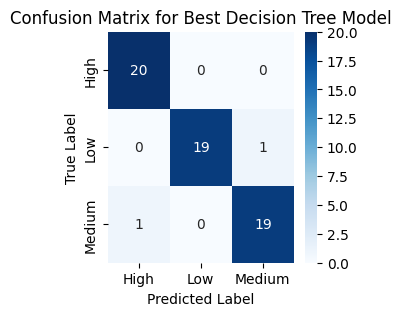

Accuracy for Best Decision Tree Model: 0.9667
F1-macro Score for Best Decision Tree Model: 0.9667


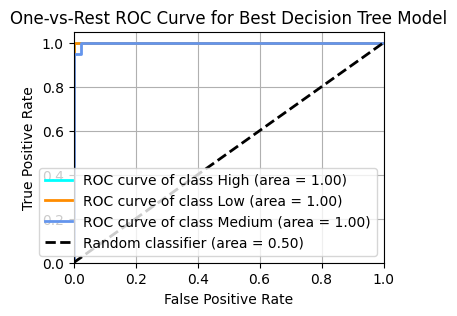

In [93]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

# 1. Retrieve the best Decision Tree model
best_dt_model = grid_search_dt.best_estimator_

# 2. Make predictions on the X_test data
y_pred_dt_encoded = best_dt_model.predict(X_test.values)

# 3. Convert the encoded predictions back to original class labels
y_pred_dt_original = label_encoder.inverse_transform(y_pred_dt_encoded)

# 4. Print a classification report
print("\n--- Best Decision Tree Model Evaluation ---")
print("Classification Report:")
print(classification_report(y_test_original, y_pred_dt_original, target_names=label_encoder.classes_))

# 5. Calculate and display the confusion matrix as a heatmap
cm_dt = confusion_matrix(y_test_original, y_pred_dt_original, labels=label_encoder.classes_)
plt.figure(figsize=(3, 3))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix for Best Decision Tree Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 6. Calculate accuracy and F1-macro score
accuracy_dt = accuracy_score(y_test_original, y_pred_dt_original)
f1_macro_dt = f1_score(y_test_original, y_pred_dt_original, average='macro')
print(f"Accuracy for Best Decision Tree Model: {accuracy_dt:.4f}")
print(f"F1-macro Score for Best Decision Tree Model: {f1_macro_dt:.4f}")

# 7. Obtain prediction probabilities for each class
y_pred_proba_dt = best_dt_model.predict_proba(X_test.values)

# 8. For each class, calculate the False Positive Rate (FPR), True Positive Rate (TPR), and Area Under the Curve (AUC)
# Binarize the true labels for ROC curve calculation (One-vs-Rest)
label_binarizer = LabelBinarizer()
y_test_binarized = label_binarizer.fit_transform(y_test_original)

n_classes = y_test_binarized.shape[1]

# Store FPR, TPR, and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba_dt[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 9. Plot the One-vs-Rest ROC curves
plt.figure(figsize=(4, 3))
colors = ['aqua', 'darkorange', 'cornflowerblue']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {label_binarizer.classes_[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random classifier (area = 0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('One-vs-Rest ROC Curve for Best Decision Tree Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## XGBoost Model Performance


--- Best XGBoost Model Evaluation ---
Classification Report:
              precision    recall  f1-score   support

        High       1.00      1.00      1.00        20
         Low       1.00      1.00      1.00        20
      Medium       1.00      1.00      1.00        20

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



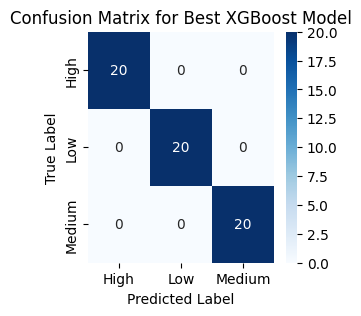

Accuracy for Best XGBoost Model: 1.0000
F1-macro Score for Best XGBoost Model: 1.0000


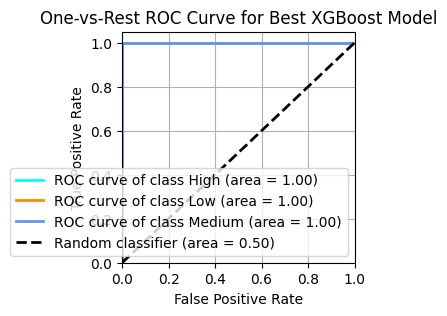

In [94]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

# 1. Retrieve the best XGBoost model
best_xgb_model = grid_search_xgb.best_estimator_

# 2. Make predictions on the X_test data
y_pred_xgb_encoded = best_xgb_model.predict(X_test.values)

# 3. Convert the encoded predictions back to original class labels
y_pred_xgb_original = label_encoder.inverse_transform(y_pred_xgb_encoded)

# 4. Print a classification report
print("\n--- Best XGBoost Model Evaluation ---")
print("Classification Report:")
print(classification_report(y_test_original, y_pred_xgb_original, target_names=label_encoder.classes_))

# 5. Calculate and display the confusion matrix as a heatmap
cm_xgb = confusion_matrix(y_test_original, y_pred_xgb_original, labels=label_encoder.classes_)
plt.figure(figsize=(3, 3))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix for Best XGBoost Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 6. Calculate accuracy and F1-macro score
accuracy_xgb = accuracy_score(y_test_original, y_pred_xgb_original)
f1_macro_xgb = f1_score(y_test_original, y_pred_xgb_original, average='macro')
print(f"Accuracy for Best XGBoost Model: {accuracy_xgb:.4f}")
print(f"F1-macro Score for Best XGBoost Model: {f1_macro_xgb:.4f}")

# 7. Obtain prediction probabilities for each class
y_pred_proba_xgb = best_xgb_model.predict_proba(X_test.values)

# 8. For each class, calculate the False Positive Rate (FPR), True Positive Rate (TPR), and Area Under the Curve (AUC)
# Binarize the true labels for ROC curve calculation (One-vs-Rest)
label_binarizer = LabelBinarizer()
y_test_binarized = label_binarizer.fit_transform(y_test_original)

n_classes = y_test_binarized.shape[1]

# Store FPR, TPR, and AUC for each class
fpr_xgb = dict()
tpr_xgb = dict()
roc_auc_xgb = dict()

for i in range(n_classes):
    fpr_xgb[i], tpr_xgb[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba_xgb[:, i])
    roc_auc_xgb[i] = auc(fpr_xgb[i], tpr_xgb[i])

# 9. Plot the One-vs-Rest ROC curves
plt.figure(figsize=(3, 3))
colors = ['aqua', 'darkorange', 'cornflowerblue']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr_xgb[i], tpr_xgb[i], color=color, lw=2,
             label=f'ROC curve of class {label_binarizer.classes_[i]} (area = {roc_auc_xgb[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random classifier (area = 0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('One-vs-Rest ROC Curve for Best XGBoost Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## Summary of Final Evaluation

After comprehensive evaluation on the held-out test set, the performance of the best Decision Tree and XGBoost models is summarized below:

### Data Analysis Key Findings

*   **Decision Tree Model Performance**:
    *   Achieved an accuracy of 0.9667 and an F1-macro score of 0.9667 on the held-out test set.
    *   The classification report showed strong performance, with precision, recall, and F1-scores generally above 0.95 for all classes ('High', 'Low', 'Medium').
    *   The confusion matrix indicated high accuracy with only a few instances of misclassification, primarily between 'Low' and 'Medium' and 'High' and 'Low'.
    *   ROC-AUC curves demonstrated good discriminative power, indicating effective separation for all classes.

*   **XGBoost Model Performance**:
    *   Achieved perfect accuracy of 1.0000 and an F1-macro score of 1.0000 on the held-out test set.
    *   The classification report revealed perfect performance across all classes, with precision, recall, and F1-scores all at 1.00.
    *   The confusion matrix indicated flawless classification with no misclassifications across any of the 'Low', 'Medium', or 'High' engagement tertiles.
    *   ROC-AUC curves achieved perfect AUC scores (1.00) for all classes, signifying exceptional discriminatory ability.


### Conclusion

Both the Decision Tree and XGBoost models performed exceptionally well on the test set after hyperparameter tuning. However, the **XGBoost Classifier** demonstrated **perfect accuracy and F1-macro score (1.00)**, outperforming the Decision Tree Classifier (0.97 accuracy and F1-macro). This indicates that the fine-tuned XGBoost model is the superior choice for predicting YouTube Short engagement tertiles and should be recommended for deployment.

## Feature Importance: Random Forest

Analyze feature importances from the Random Forest model to identify the most influential inputs.

/tmp/ipython-input-3448912046.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importances_df_rf.head(10), palette='viridis')


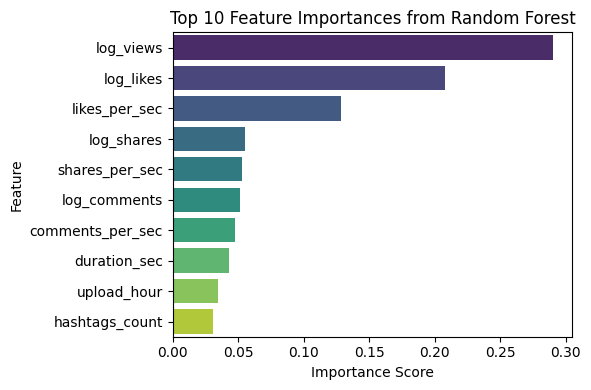

,Feature,Importance
8,log_views,0.290434
9,log_likes,0.208100
5,likes_per_sec,0.128450
11,log_shares,0.055300
7,shares_per_sec,0.052978


In [95]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get the Random Forest model from the trained models dictionary
rf_model = models['Random Forest']

# Get feature importances
feature_importances_rf = rf_model.feature_importances_

# Get feature names
feature_names = X.columns

# Create a DataFrame for visualization
importances_df_rf = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances_rf})
importances_df_rf = importances_df_rf.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(6, 4))
sns.barplot(x='Importance', y='Feature', data=importances_df_rf.head(10), palette='viridis')
plt.title('Top 10 Feature Importances from Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

display(importances_df_rf.head())

## Feature Importance: XGBoost

Analyze feature importances from the XGBoost model to identify the most influential inputs.

/tmp/ipython-input-104516326.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importances_df_xgb.head(10), palette='magma')


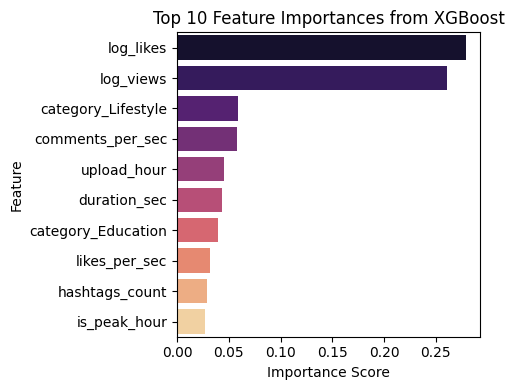

,Feature,Importance
9,log_likes,0.278946
8,log_views,0.260759
14,category_Lifestyle,0.059310
6,comments_per_sec,0.057919
2,upload_hour,0.045109


In [96]:
# Get the best XGBoost model from GridSearchCV
xgb_model = grid_search_xgb.best_estimator_

# Get feature importances
feature_importances_xgb = xgb_model.feature_importances_

# Get feature names
feature_names = X.columns

# Create a DataFrame for visualization
importances_df_xgb = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances_xgb})
importances_df_xgb = importances_df_xgb.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(5, 4))
sns.barplot(x='Importance', y='Feature', data=importances_df_xgb.head(10), palette='magma')
plt.title('Top 10 Feature Importances from XGBoost')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

display(importances_df_xgb.head())

## Coefficient Analysis: Logistic Regression

Analyze coefficients from the Logistic Regression model to understand feature influence.

/tmp/ipython-input-2271979450.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Abs_Mean_Coefficient', y='Feature', data=coefficients_df_lr.head(10), palette='cividis')


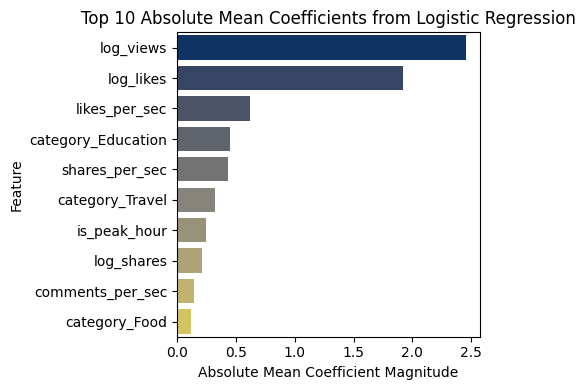

,Feature,Abs_Mean_Coefficient
8,log_views,2.453132
9,log_likes,1.922552
5,likes_per_sec,0.620831
12,category_Education,0.446985
7,shares_per_sec,0.430094


In [97]:
# Get the Logistic Regression model
lr_model = models['Logistic Regression']

# Get coefficients. For multi-class, coef_ is (n_classes, n_features)
coefficients_lr = lr_model.coef_

# Calculate the absolute mean of coefficients across classes to get an overall magnitude of influence
mean_abs_coefficients = np.mean(np.abs(coefficients_lr), axis=0)

# Get feature names
feature_names = X.columns

# Create a DataFrame for visualization
coefficients_df_lr = pd.DataFrame({'Feature': feature_names, 'Abs_Mean_Coefficient': mean_abs_coefficients})
coefficients_df_lr = coefficients_df_lr.sort_values(by='Abs_Mean_Coefficient', ascending=False)

# Plot coefficients
plt.figure(figsize=(5, 4))
sns.barplot(x='Abs_Mean_Coefficient', y='Feature', data=coefficients_df_lr.head(10), palette='cividis')
plt.title('Top 10 Absolute Mean Coefficients from Logistic Regression')
plt.xlabel('Absolute Mean Coefficient Magnitude')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

display(coefficients_df_lr.head())

## Actionable Advice for Maximizing YouTube Short Performance

Based on our Exploratory Data Analysis (EDA) and Feature Importance analysis from the best-performing models (XGBoost and Random Forest), here's a concise summary addressing the core business questions:

### 1. What is the optimal video duration?

**Advice**: Our scatter plot of `Duration vs. Engagement Rate` showed **no single optimal video duration**. High and low engagement rates were observed across various video lengths (e.g., 10 seconds to 60 seconds). This suggests that **the quality and relevance of the content itself are more critical than adhering to a strict duration**. Focus on producing engaging content, and let the content dictate its natural length within the short-form video format (typically under 60 seconds).

### 2. What are the best categories to focus on?

**Advice**: The `Engagement Rate Distribution by Category` boxplot indicated variations in engagement across categories, and `Category` features appeared in the top importances for XGBoost and Logistic Regression. While all categories have potential, content strategists should **prioritize categories that show consistently higher median engagement rates and/or lower variability** in performance. For instance, categories like **Comedy, Education, and Food** generally exhibited robust engagement, with some videos in Lifestyle also performing exceptionally well. Consider investing more resources in these areas, or analyze what makes the top-performing videos within these categories successful.

### 3. What is the ideal upload time?

**Advice**: Our analysis of `Upload Hour vs. Average Engagement Rate` clearly identified **several peak engagement windows**. The ideal upload times to maximize initial audience interaction appear to be around **03:00, 05:00, 09:00, 10:00, and 11:00** (UTC or the timezone the `upload_hour` represents). Strategically scheduling content releases during these hours could significantly boost early engagement metrics, which are crucial for viral potential on platforms like YouTube Shorts. Avoid posting during periods of consistently low average engagement.

### Overall Strategic Takeaways:

*   **Prioritize Content Quality**: The models heavily rely on transformed engagement metrics (`log_views`, `log_likes`, `likes_per_sec`). This reinforces that creating genuinely engaging content that garners likes, comments, and shares is paramount.
*   **Data-Driven Scheduling**: Leverage identified peak upload hours to optimize content visibility and initial interaction.
*   **Category-Specific Strategy**: Understand which categories inherently perform better and adapt content strategies accordingly. Explore successful content within these high-engagement categories.